In [1]:
import tstrippy
import astropy.units as u
import astropy.constants as const
import astropy.coordinates as coord
import numpy as np
import matplotlib.pyplot as plt
import datetime
import bar_sensitivity_integration_timestep_and_time as bsitt

In [2]:
def backward_orbit(integrationparameters,staticgalaxy,initialkinematics,galacticbar):
    nObj = 1 # only integrating one object
    currenttime,dt,Ntimestep=integrationparameters
    MWname, MWparams = staticgalaxy
    x0,y0,z0,vx0,vy0,vz0 = initialkinematics
    barname,barparams,barpolycoeff = galacticbar

    tstrippy.integrator.setstaticgalaxy(MWname,MWparams)
    tstrippy.integrator.setintegrationparameters(currenttime.value,dt.value,Ntimestep)
    tstrippy.integrator.setinitialkinematics(x0,y0,z0,vx0,vy0,vz0)
    tstrippy.integrator.initgalacticbar(barname,barparams,barpolycoeff)
    tstrippy.integrator.setbackwardorbit()
    xBackward,yBackward,zBackward,vxBackward,vyBackward,vzBackward=tstrippy.integrator.leapfrogintime(Ntimestep,nObj)
    endtime=datetime.datetime.now()
    backtimestamps = tstrippy.integrator.timestamps.copy()
    tstrippy.integrator.deallocate()
    orbit = [xBackward[0],yBackward[0],zBackward[0],vxBackward[0],vyBackward[0],vzBackward[0]]
    return backtimestamps,orbit


In [3]:
def backward_orbit_no_bar(integrationparameters,staticgalaxy,initialkinematics):
    nObj = 1 # only integrating one object
    currenttime,dt,Ntimestep=integrationparameters
    MWname, MWparams = staticgalaxy
    x0,y0,z0,vx0,vy0,vz0 = initialkinematics

    tstrippy.integrator.setstaticgalaxy(MWname,MWparams)
    tstrippy.integrator.setintegrationparameters(currenttime.value,dt.value,Ntimestep)
    tstrippy.integrator.setinitialkinematics(x0,y0,z0,vx0,vy0,vz0)
    tstrippy.integrator.setbackwardorbit()
    xBackward,yBackward,zBackward,vxBackward,vyBackward,vzBackward=tstrippy.integrator.leapfrogintime(Ntimestep,nObj)
    endtime=datetime.datetime.now()
    backtimestamps = tstrippy.integrator.timestamps.copy()
    tstrippy.integrator.deallocate()
    orbit = [xBackward[0],yBackward[0],zBackward[0],vxBackward[0],vyBackward[0],vzBackward[0]]
    return backtimestamps,orbit


In [4]:
targetGC = "NGC5139"
# load units
unitT, unitV, unitD, unitM, unitG, G=bsitt.loadunits()
# Load the galaxy parameters
MWparams, MWrefframe = bsitt.loadGalaxy()
# Load the bar parameters
barparams = bsitt.barparams_ferrone2023()
# Load the bar movement
barpolycoeff = bsitt.bar_movement_ferrone2023()
# Reduce the mass of the disks to account for the bar
MWparams[5] = 1120.0 * 2.32*10**7 
MWparams[8] = 1190.0 * 2.32*10**7 
# Extract the initial conditions of the target globular cluster
x0,y0,z0,vx0,vy0,vz0 = bsitt.pick_globular_cluster(targetGC, MWrefframe)
#### Begin storing the input data for the integrator
Galaxy = ["pouliasis2017pii", MWparams]
bar = ["longmuralibar", barparams, barpolycoeff]
initialkinematics = [x0,y0,z0,vx0,vy0,vz0]

In [5]:
integrationtime = 5e9
timestep = 1e5
Ntimestep=int(integrationtime/timestep)
T,dt=integrationtime*u.yr,timestep*u.yr
currenttime = 0.0*unitT
dt = dt.to(unitT)
integrationparams = [currenttime,dt,Ntimestep]

In [6]:
timestamps,backorbit = backward_orbit(integrationparams,Galaxy,initialkinematics,bar)
# flip to get the forward orbit
timestamps = timestamps[::-1]
xH= backorbit[0][::-1]
yH= backorbit[1][::-1]
zH= backorbit[2][::-1]
vxH= -backorbit[3][::-1]
vyH= -backorbit[4][::-1]
vzH= -backorbit[5][::-1]

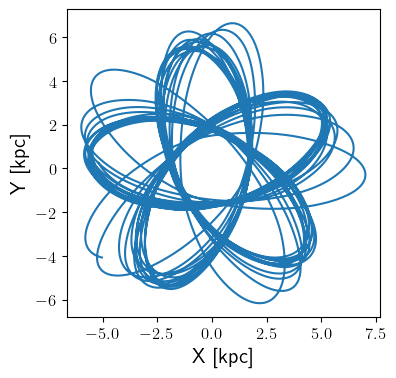

In [7]:
fig,axis=plt.subplots(1,1,figsize=(5,4))
axis.plot(xH,yH)
axis.set_xlabel("X [kpc]")
axis.set_ylabel("Y [kpc]")
axis.set_aspect('equal')

## Prepare the star particles

In [8]:
NP = int(1e3)
GCdata  =   tstrippy.Parsers.baumgardtMWGCs().data
clusterIndex = np.where(GCdata['Cluster']==targetGC)[0][0]
Mass = GCdata['Mass'][clusterIndex] 
halfMassRadius = GCdata['rh_m'][clusterIndex]
bPlummer = tstrippy.ergodic.convertHalfMassRadiusToPlummerRadius(halfmassradius=halfMassRadius)
xp,yp,zp,vxp,vyp,vzp=tstrippy.ergodic.isotropicplummer(G,halfMassRadius.value,bPlummer.value,NP)

In [9]:
tstrippy.integrator.setstaticgalaxy(*Galaxy)
tstrippy.integrator.setintegrationparameters(timestamps[0],dt.value,Ntimestep)
tstrippy.integrator.setinitialkinematics(xp+xH[0],yp+yH[0],zp+zH[0],vxp+vxH[0],vyp+vyH[0],vzp+vzH[0])
tstrippy.integrator.initgalacticbar(*bar)
xpt,ypt,zpt,vxpt,vypt,vzpt=tstrippy.integrator.leapfrogintime(Ntimestep,NP)
forwardtimestamps = tstrippy.integrator.timestamps.copy()
print(tstrippy.integrator.currenttime)
tstrippy.integrator.deallocate()

-1.216474837528736e-16


Text(0.5, 1.0, 'NGC5139 particles only, no force from host')

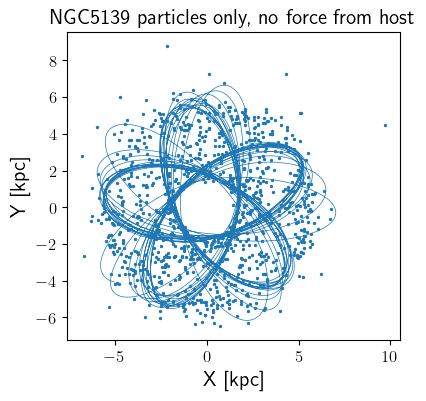

In [10]:
fig,axis=plt.subplots(1,1,figsize=(5,4))
axis.plot(xH,yH,zorder=0,linewidth=0.5)
axis.scatter(xpt[:,-1],ypt[:,-1],s=2,zorder=1)
axis.set_xlabel("X [kpc]")
axis.set_ylabel("Y [kpc]")
axis.set_aspect('equal')
axis.set_title(targetGC+" particles only, no force from host")

In [11]:
tstrippy.integrator.setstaticgalaxy(*Galaxy)
tstrippy.integrator.setintegrationparameters(timestamps[0],dt.value,Ntimestep)
tstrippy.integrator.setinitialkinematics(xp+xH[0],yp+yH[0],zp+zH[0],vxp+vxH[0],vyp+vyH[0],vzp+vzH[0])
tstrippy.integrator.initgalacticbar(*bar)
tstrippy.integrator.inithostperturber(timestamps,xH,yH,zH,vxH,vyH,vzH,Mass.value,bPlummer.value)
xpt,ypt,zpt,vxpt,vypt,vzpt=tstrippy.integrator.leapfrogintime(Ntimestep,NP)
forwardtimestamps = tstrippy.integrator.timestamps.copy()
print(tstrippy.integrator.currenttime)
tstrippy.integrator.deallocate()

-1.216474837528736e-16


Text(0.5, 1.0, 'zoomed')

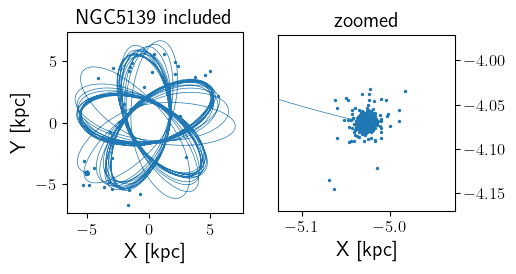

In [12]:
fig,axis=plt.subplots(1,2,figsize=(5,4))
axis[0].plot(xH,yH,zorder=0,linewidth=0.5)
axis[0].scatter(xpt[:,-1],ypt[:,-1],s=2,zorder=1)
axis[0].set_xlabel("X [kpc]")
axis[0].set_ylabel("Y [kpc]")
axis[0].set_aspect('equal')
axis[0].set_title(targetGC+" included")
dx = .1
axis[1].plot(xH,yH,zorder=0,linewidth=0.5)
axis[1].scatter(xpt[:,-1],ypt[:,-1],s=2,zorder=1)
axis[1].set_xlim(xH[-1]-dx,xH[-1]+dx)
axis[1].set_ylim(yH[-1]-dx,yH[-1]+dx)
axis[1].set_xlabel("X [kpc]")
# put y-ticks on the right side
axis[1].yaxis.tick_right()
axis[1].set_aspect('equal')
axis[1].set_title("zoomed")


now do it without a bar

In [13]:
timestamps,back_no_bar=backward_orbit_no_bar(integrationparams,Galaxy,initialkinematics)
timestamps = timestamps[::-1]
xH= back_no_bar[0][::-1]
yH= back_no_bar[1][::-1]
zH= back_no_bar[2][::-1]
vxH= -back_no_bar[3][::-1]
vyH= -back_no_bar[4][::-1]
vzH= -back_no_bar[5][::-1]

In [14]:
tstrippy.integrator.setstaticgalaxy(*Galaxy)
tstrippy.integrator.setintegrationparameters(timestamps[0],dt.value,Ntimestep)
tstrippy.integrator.setinitialkinematics(xp+xH[0],yp+yH[0],zp+zH[0],vxp+vxH[0],vyp+vyH[0],vzp+vzH[0])
# tstrippy.integrator.initgalacticbar(*bar)
tstrippy.integrator.inithostperturber(timestamps,xH,yH,zH,vxH,vyH,vzH,Mass.value,bPlummer.value)
xpt,ypt,zpt,vxpt,vypt,vzpt=tstrippy.integrator.leapfrogintime(Ntimestep,NP)
forwardtimestamps = tstrippy.integrator.timestamps.copy()
tstrippy.integrator.deallocate()

Text(0.5, 1.0, 'zoomed')

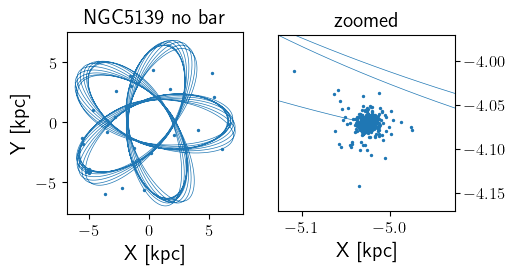

In [ ]:
fig,axis=plt.subplots(1,2,figsize=(5,4))
axis[0].plot(xH,yH,zorder=0,linewidth=0.5)
axis[0].scatter(xpt[:,-1],ypt[:,-1],s=2,zorder=1)
axis[0].set_xlabel("X [kpc]")
axis[0].set_ylabel("Y [kpc]")
axis[0].set_aspect('equal')
axis[0].set_title(targetGC+" no bar")
dx = .1
axis[1].plot(xH,yH,zorder=0,linewidth=0.5)
axis[1].scatter(xpt[:,-1],ypt[:,-1],s=2,zorder=1)
axis[1].set_xlim(xH[-1]-dx,xH[-1]+dx)
axis[1].set_ylim(yH[-1]-dx,yH[-1]+dx)
axis[1].set_xlabel("X [kpc]")
# put y-ticks on the right side
axis[1].yaxis.tick_right()
axis[1].set_aspect('equal')
axis[1].set_title("zoomed")


# now try with leapfroptofinal positions

In [16]:
timestamps,backorbit = backward_orbit(integrationparams,Galaxy,initialkinematics,bar)
# flip to get the forward orbit
timestamps = timestamps[::-1]
xH= backorbit[0][::-1]
yH= backorbit[1][::-1]
zH= backorbit[2][::-1]
vxH= -backorbit[3][::-1]
vyH= -backorbit[4][::-1]
vzH= -backorbit[5][::-1]

In [19]:
tstrippy.integrator.setstaticgalaxy(*Galaxy)
tstrippy.integrator.setintegrationparameters(timestamps[0],dt.value,Ntimestep)
tstrippy.integrator.setinitialkinematics(xp+xH[0],yp+yH[0],zp+zH[0],vxp+vxH[0],vyp+vyH[0],vzp+vzH[0])
tstrippy.integrator.initgalacticbar(*bar)
tstrippy.integrator.inithostperturber(timestamps,xH,yH,zH,vxH,vyH,vzH,Mass.value,bPlummer.value)
tstrippy.integrator.leapfrogtofinalpositions()
xpf= tstrippy.integrator.xf.copy()
ypf= tstrippy.integrator.yf.copy()
zpf= tstrippy.integrator.zf.copy()
vxpf= tstrippy.integrator.vxf.copy()
vypf= tstrippy.integrator.vyf.copy()
vzpf= tstrippy.integrator.vzf.copy()
forwardtimestamps = tstrippy.integrator.timestamps.copy()
tstrippy.integrator.deallocate()

 leapfrogtofinalpositions


Text(0.5, 1.0, 'zoomed')

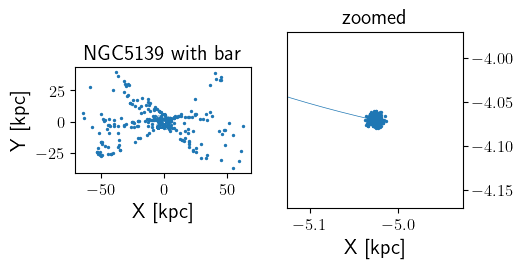

In [20]:
fig,axis=plt.subplots(1,2,figsize=(5,4))
axis[0].plot(xH,yH,zorder=0,linewidth=0.5)
axis[0].scatter(xpf,ypf,s=2,zorder=1)
axis[0].set_xlabel("X [kpc]")
axis[0].set_ylabel("Y [kpc]")
axis[0].set_aspect('equal')
axis[0].set_title(targetGC+" with bar")
dx = .1
axis[1].plot(xH,yH,zorder=0,linewidth=0.5)
axis[1].scatter(xpf,ypf,s=2,zorder=1)
axis[1].set_xlim(xH[-1]-dx,xH[-1]+dx)
axis[1].set_ylim(yH[-1]-dx,yH[-1]+dx)
axis[1].set_xlabel("X [kpc]")
# put y-ticks on the right side
axis[1].yaxis.tick_right()
axis[1].set_aspect('equal')
axis[1].set_title("zoomed")


ok, something weird with the when the bar is included  just for leapfrogtofinalpositions(). 

This is good. Just gotta debug this function tomorrow. 